# Advanced Plotting

(insert introductory statement here as needed)

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

For these exercises we will need to import multiple variables, below is an example of one way to do so.

In [36]:
monthly_output_path = "/glade/campaign/cgd/cesm/CESM2-LE/ice/proc/tseries/month_1"
run_name = "b.e21.BHISTcmip6.f09_g17.LE2-1001.001"

var_names = ['aice',
             'aicen',
             'vsnon',
             'hs',
             'fsens',
             'fsens_ai',
            ]

da_list = []

for var_name in var_names:
    files = os.path.join(monthly_output_path, var_name,
                         run_name + ".cice.h." + var_name + ".*")
    ds_in = xr.open_mfdataset(files)
    da_list.append(ds_in[var_name])
    del ds_in

ds = xr.merge(da_list)

del da_list

The next step is to read in some grid information for the `gx1v7` dipole grid used in POP and CICE. We will read in three main variables: `tarea`, `TLAT`, and `TLON`. These are the areas of the gridcells along with the latitudes and longitudes of the gridcell centers. Also, we will print the latitude array `TLAT` to see the metadata.

In [37]:
# get pop grid grid cell areas
grid = pop_tools.get_grid('POP_gx1v7')

# convert tarea to m^2
with xr.set_options(keep_attrs=True):
    grid['TAREA'] = grid['TAREA']/(1e4)
grid['TAREA'].attrs['units'] = 'm^2'

We will merge in three main variables: `tarea`, `TLAT`, and `TLON`. These are the areas of the gridcells along with the latitudes and longitudes of the gridcell centers. Note that this overwrites the dataset object from above.

In [38]:
ds = xr.merge([ds.drop(['TLAT', 'TLON', 'ULAT', 'ULON']),
               grid[['TLAT', 'TLONG', 'TAREA']].rename_dims({'nlat':'nj','nlon':'ni'})],
              compat='identical', combine_attrs='no_conflicts')

In [39]:
ds

<xarray.Dataset>
Dimensions:   (time: 1980, nj: 384, ni: 320, nc: 5)
Coordinates:
  * time      (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    NCAT      (nc) float32 dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: nj, ni, nc
Data variables:
    aice      (time, nj, ni) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    aicen     (time, nc, nj, ni) float32 dask.array<chunksize=(120, 5, 384, 320), meta=np.ndarray>
    vsnon     (time, nc, nj, ni) float32 dask.array<chunksize=(120, 5, 384, 320), meta=np.ndarray>
    hs        (time, nj, ni) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    fsens     (time, nj, ni) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    fsens_ai  (time, nj, ni) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    TLAT      (nj, ni) float64 -79.22 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG     (nj, ni) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TAREA     (nj, ni) float64 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08
Attributes: (12/13)
    units:              1
    long_name:          ice area  (aggregate)
    cell_measures:      area: tarea
    cell_methods:       time: mean
    time_rep:           averaged
    lateral_dims:       [384, 320]
    ...                 ...
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

## Example 1: Plot per-category ice area

Compare the dataset in this notebook with `aice` in the basics notebook. Notice that in this case we have an additional category dimension `nc`. `aicen` is the per-category ice area fraction. We demonstrate plotting a per-category variable below. We also plot the full sea ice concentration in the final plot.

Text(0.5, 1.0, 'Sea Ice Concentration')

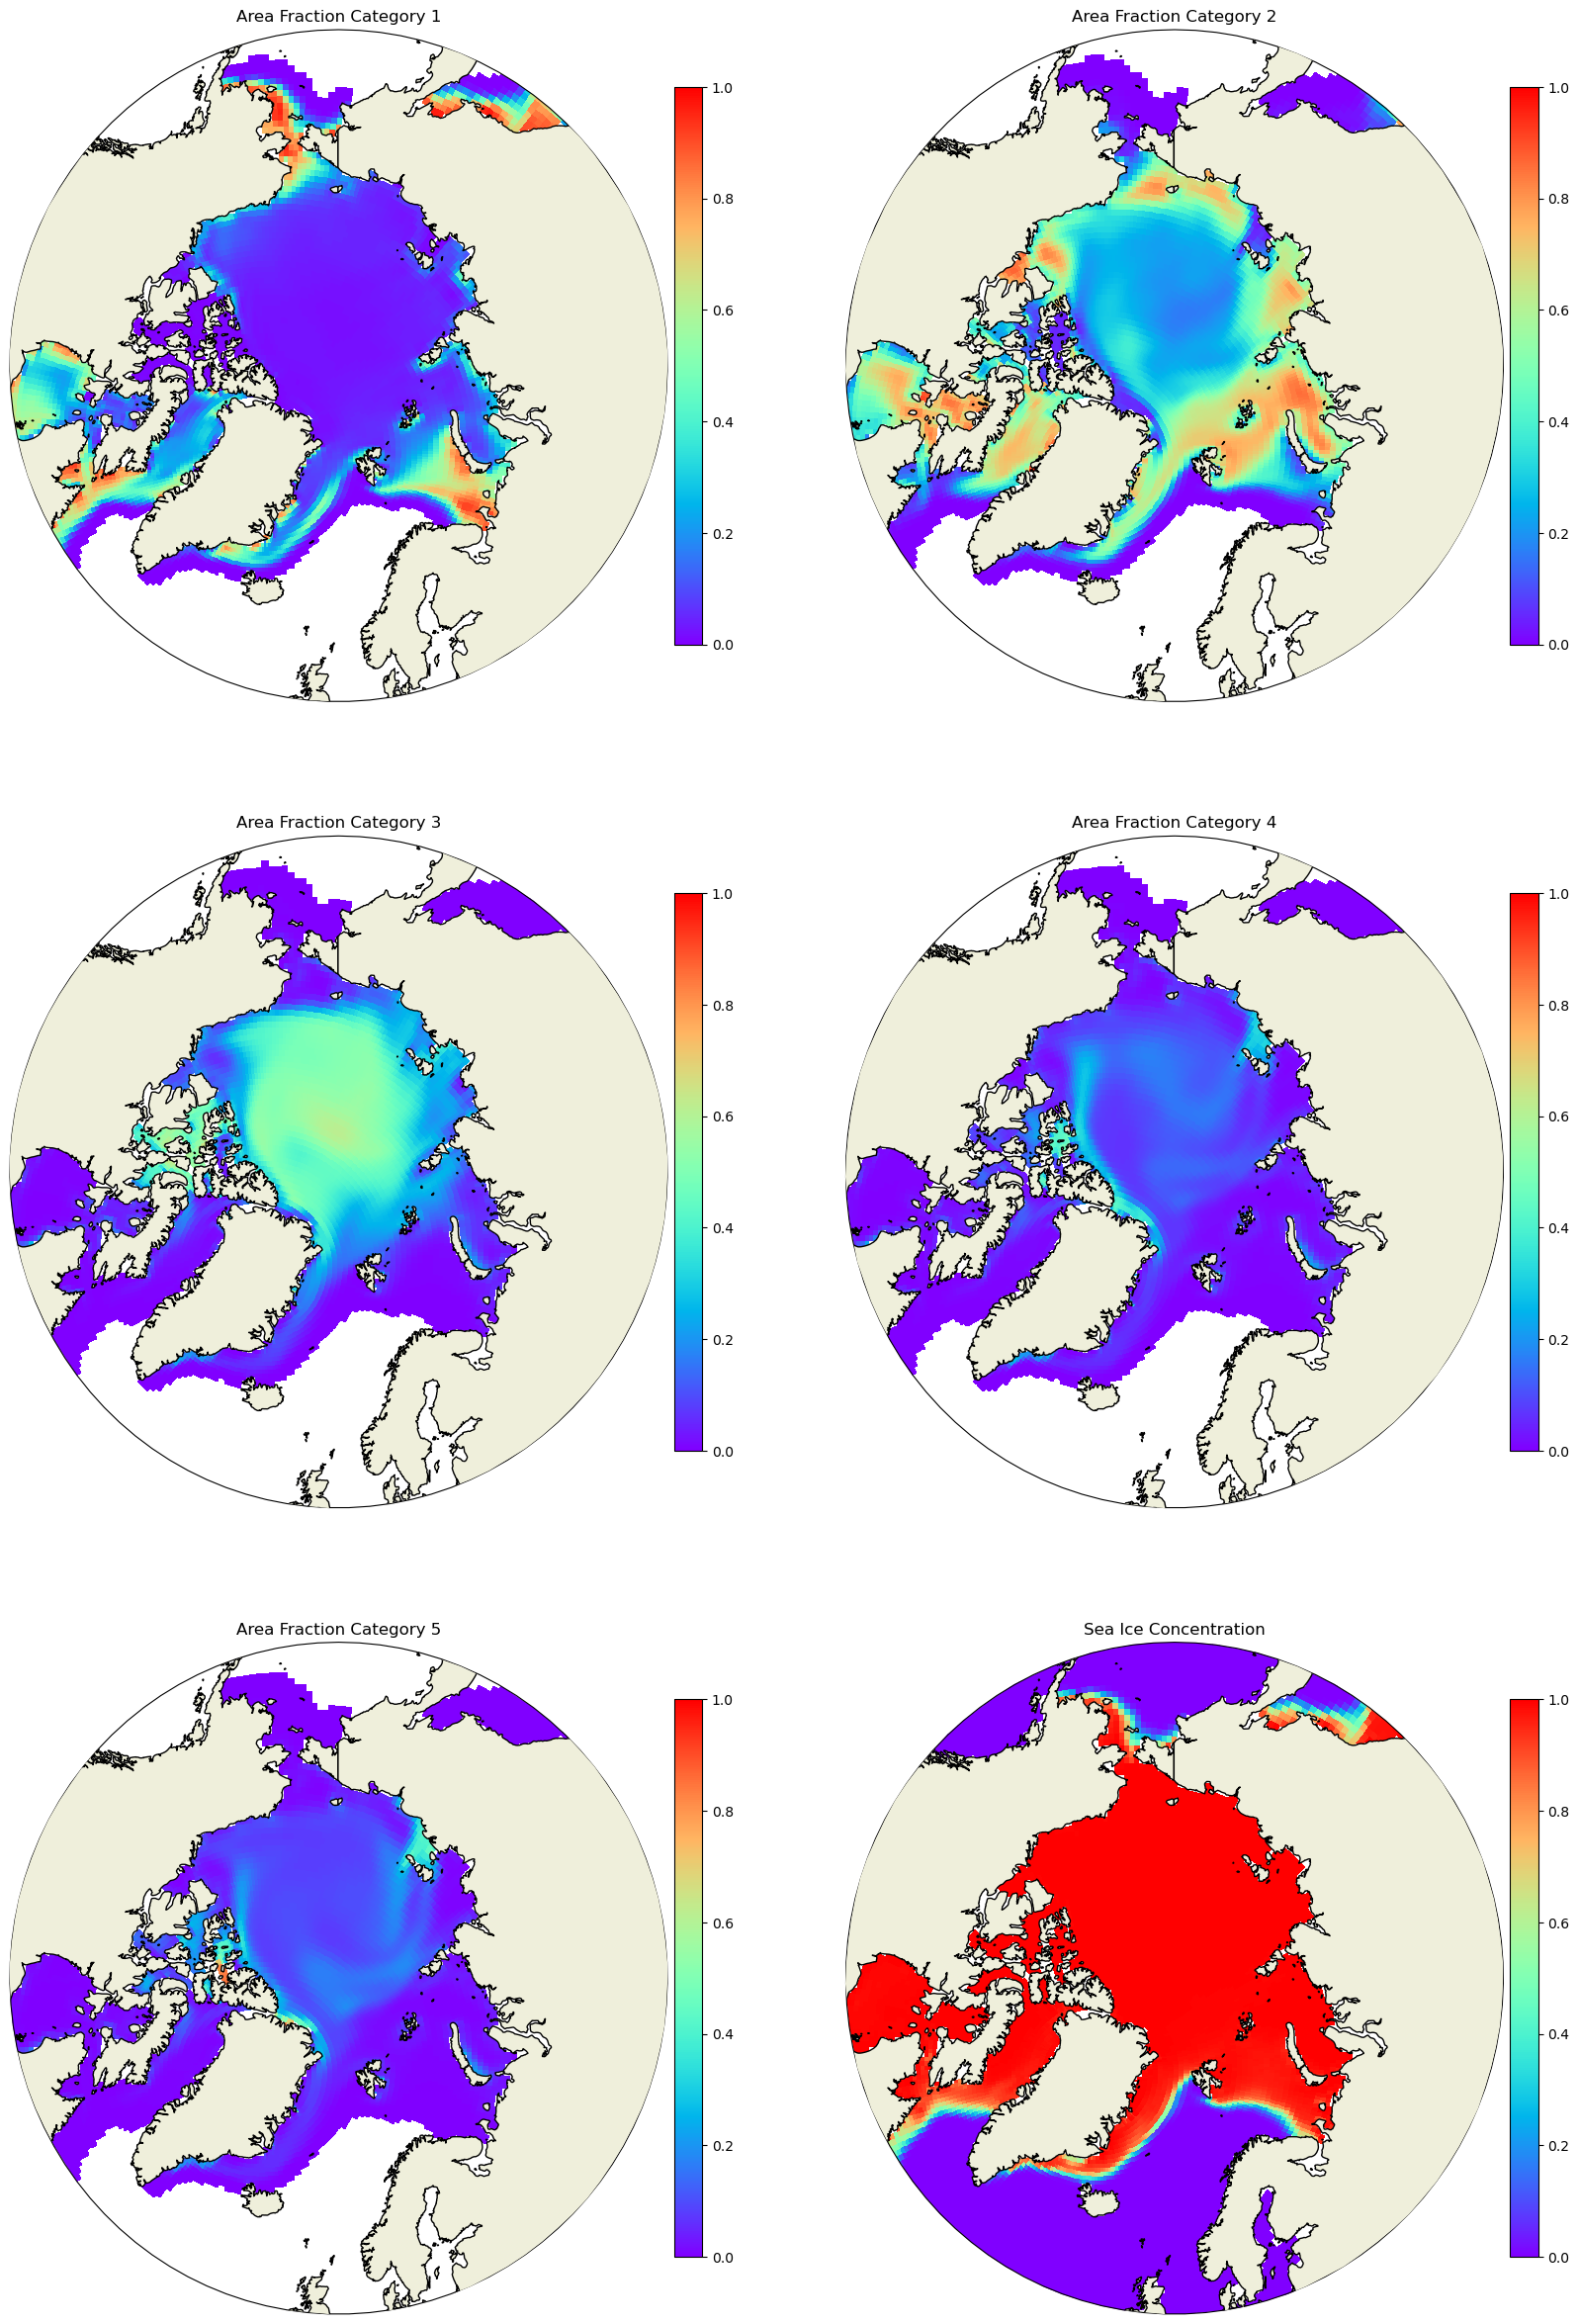

In [31]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

cmap = plt.cm.get_cmap('rainbow')  


fig, axs = plt.subplots(3, 2, figsize=(20,30),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
axs = np.ravel(axs)

for i in ds.nc.values:
    ax = axs[i]
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(ds['TLONG'],
                       ds['TLAT'],
                       ds['aicen'].sel({'time':'1850-02-01 00:00:00',
                                        'nc':i}).squeeze(),
                       cmap=cmap,vmax=1,vmin=0,
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    ax.set_title('Area Fraction Category ' + str(i+1))

# Aice in the final subplot
ax = axs[-1]
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
this=ax.pcolormesh(ds['TLONG'],
                   ds['TLAT'],
                   ds['aice'].sel({'time':'1850-02-01 00:00:00'}).squeeze(),
                   cmap=cmap,vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
ax.set_title('Sea Ice Concentration')

## Example 2: Plot per-category snow thickness

Internally, the model actually stores the snow **volume** for each category, not the thickness. To get the thickness we need to divide `vsnon` by `aicen` (the per category area.

We will also plot the grid cell mean snow thickness. How does this compare with the per-category values?

In [40]:
ds['hsn'] = ds['vsnon'] / ds['aicen']

Text(0.5, 1.0, 'Average Snow Depth (m)')

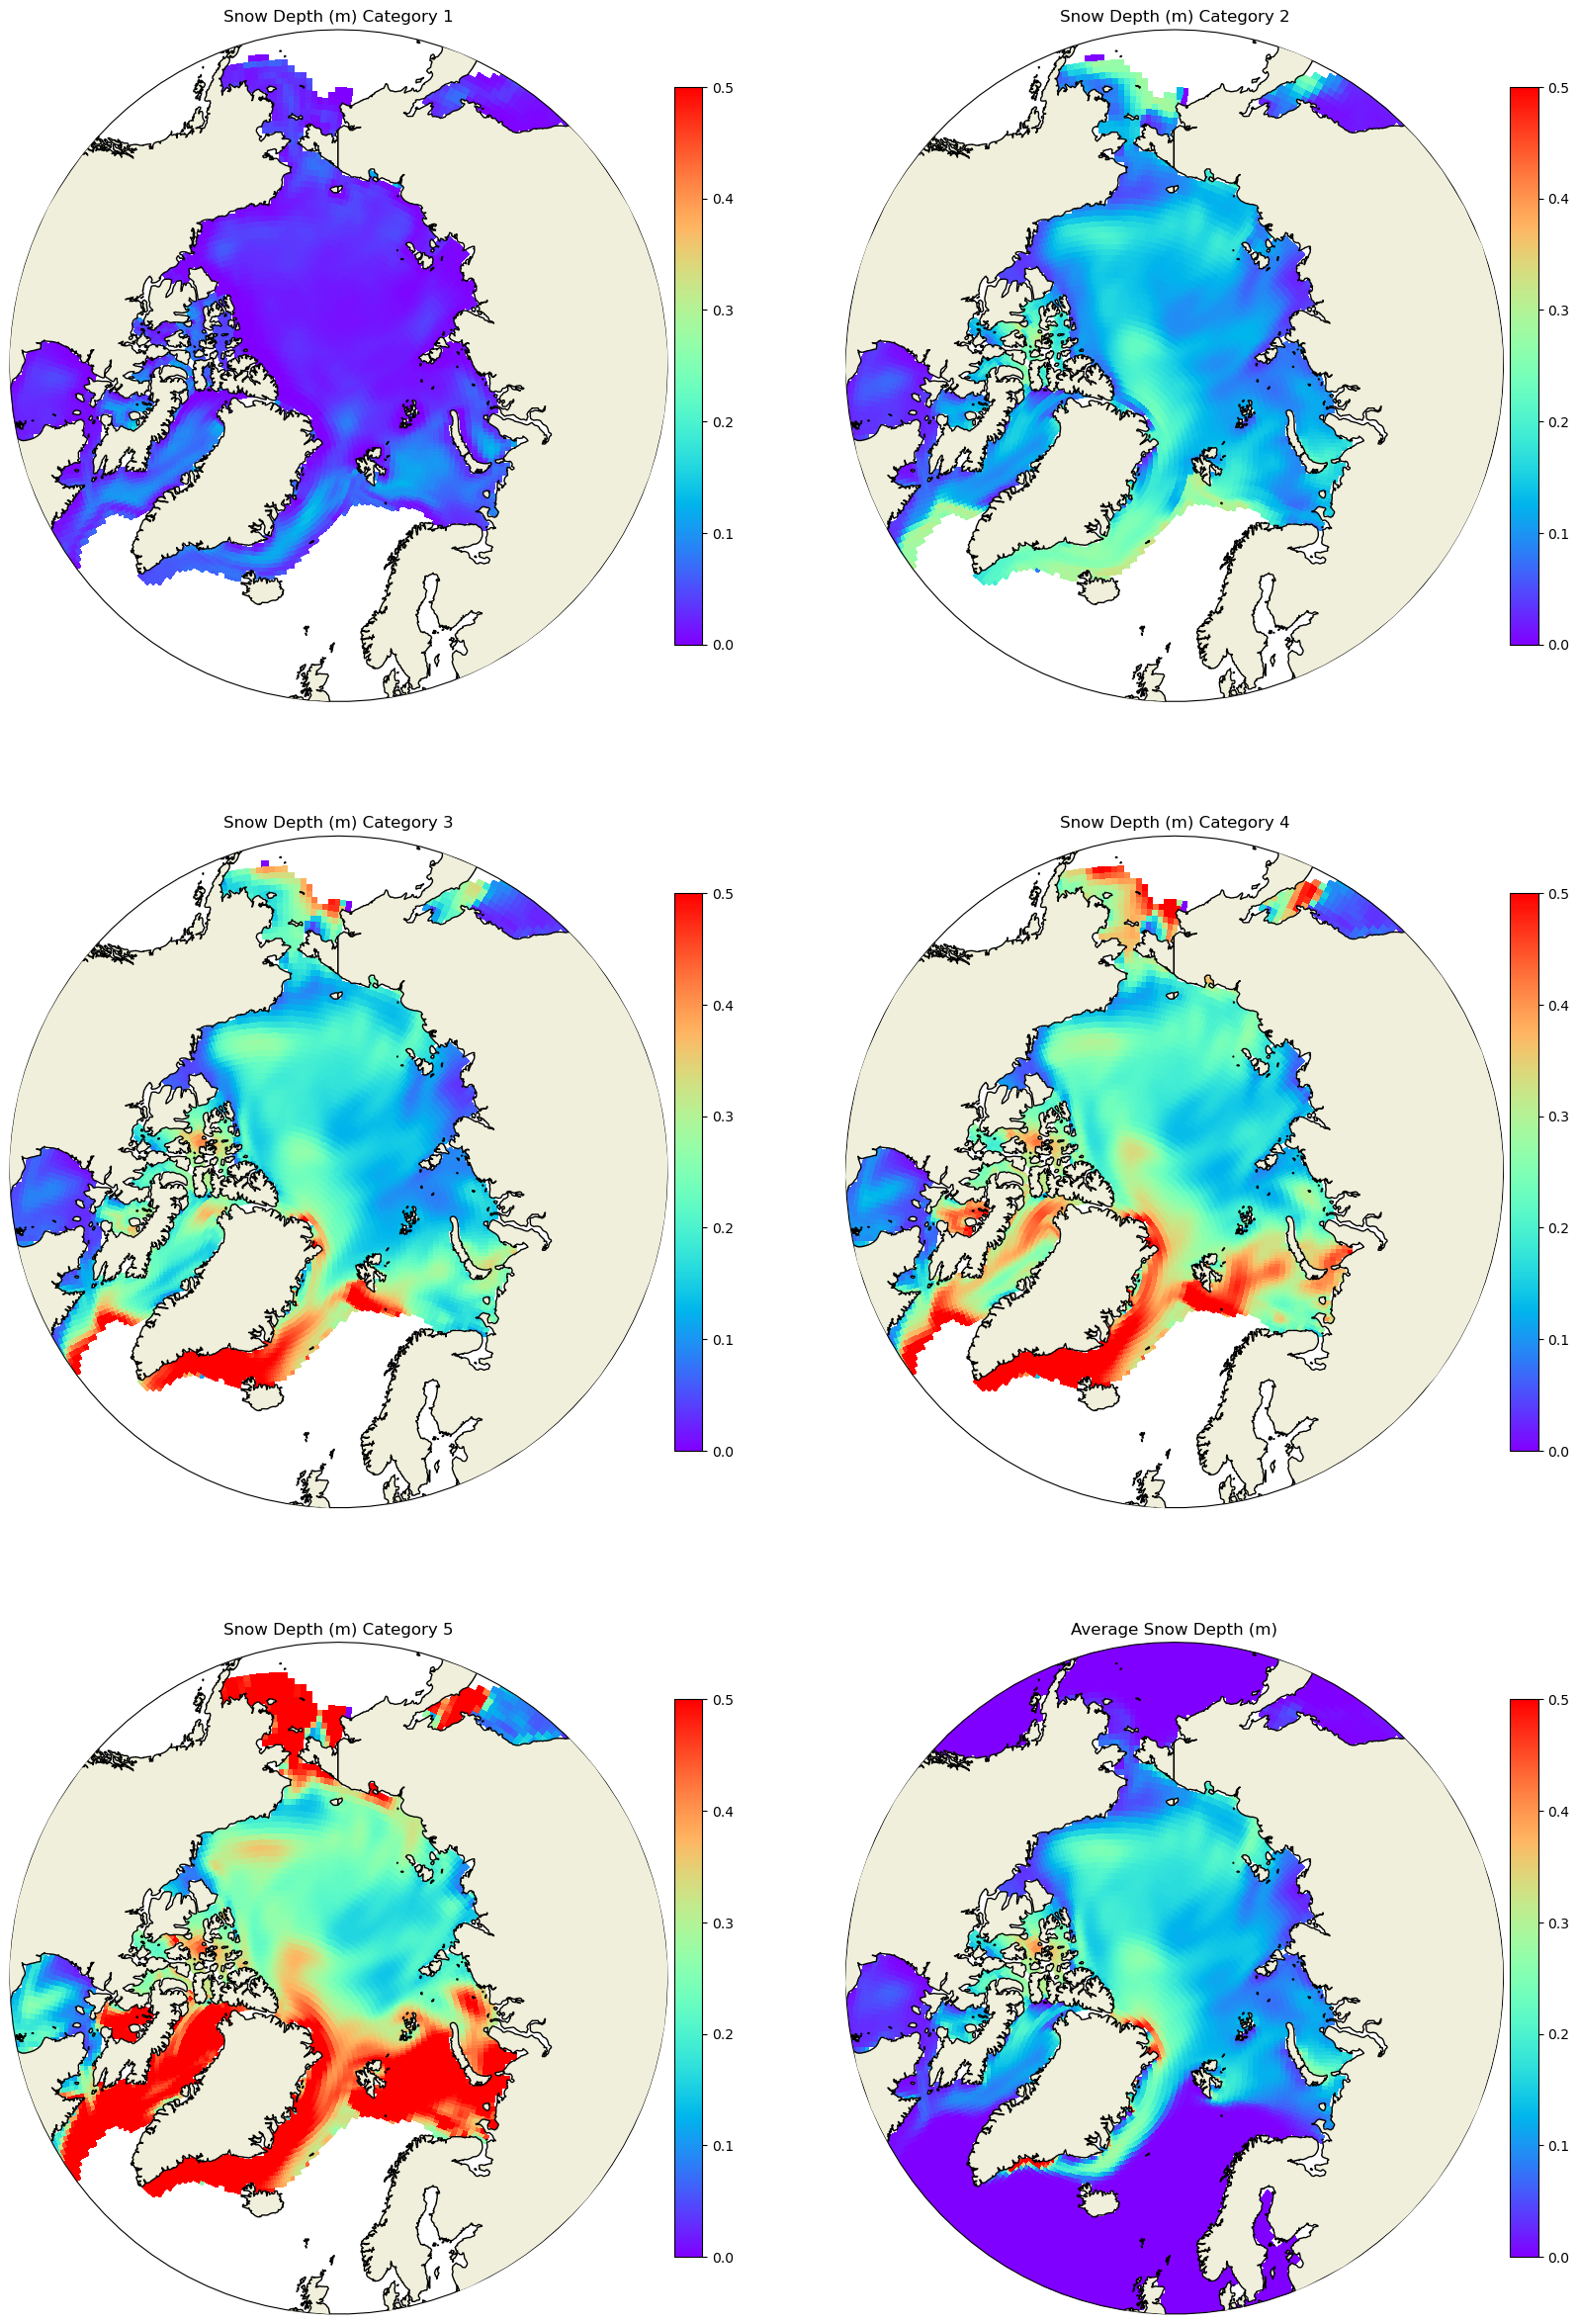

In [35]:
# Max snow depth for colorbars
hs_max = 0.5 

# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

cmap = plt.cm.get_cmap('rainbow')  


fig, axs = plt.subplots(3, 2, figsize=(20,30),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
axs = np.ravel(axs)

for i in ds.nc.values:
    ax = axs[i]
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(ds['TLONG'],
                       ds['TLAT'],
                       ds['hsn'].sel({'time':'1850-02-01 00:00:00',
                                        'nc':i}).squeeze(),
                       cmap=cmap,vmax=hs_max,vmin=0,
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    ax.set_title('Snow Depth (m) Category ' + str(i+1))

# Aice in the final subplot
ax = axs[-1]
ax.set_boundary(circle, transform=ax.transAxes)
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
this=ax.pcolormesh(ds['TLONG'],
                   ds['TLAT'],
                   ds['hs'].sel({'time':'1850-02-01 00:00:00'}).squeeze(),
                   cmap=cmap,vmax=hs_max,vmin=0,
                   transform=ccrs.PlateCarree())
plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
ax.set_title('Average Snow Depth (m)')

## Example 3: Ice area tracer

The default CICE outputs are averaged over the entire grid cell, including the open water. Thus if a grid cell happened to be half covered in 1-m-thick ice and half open water then `hi` would be 0.5 m. Some tracers are written out just for the ice-covered area of the grid cell. These are indicated by have `_ai` appended to the variable name.

Below is an example of this for the sensible heat flux.

In [41]:
ds['fsens_diff'] = ds['fsens_ai'] - ds['fsens']

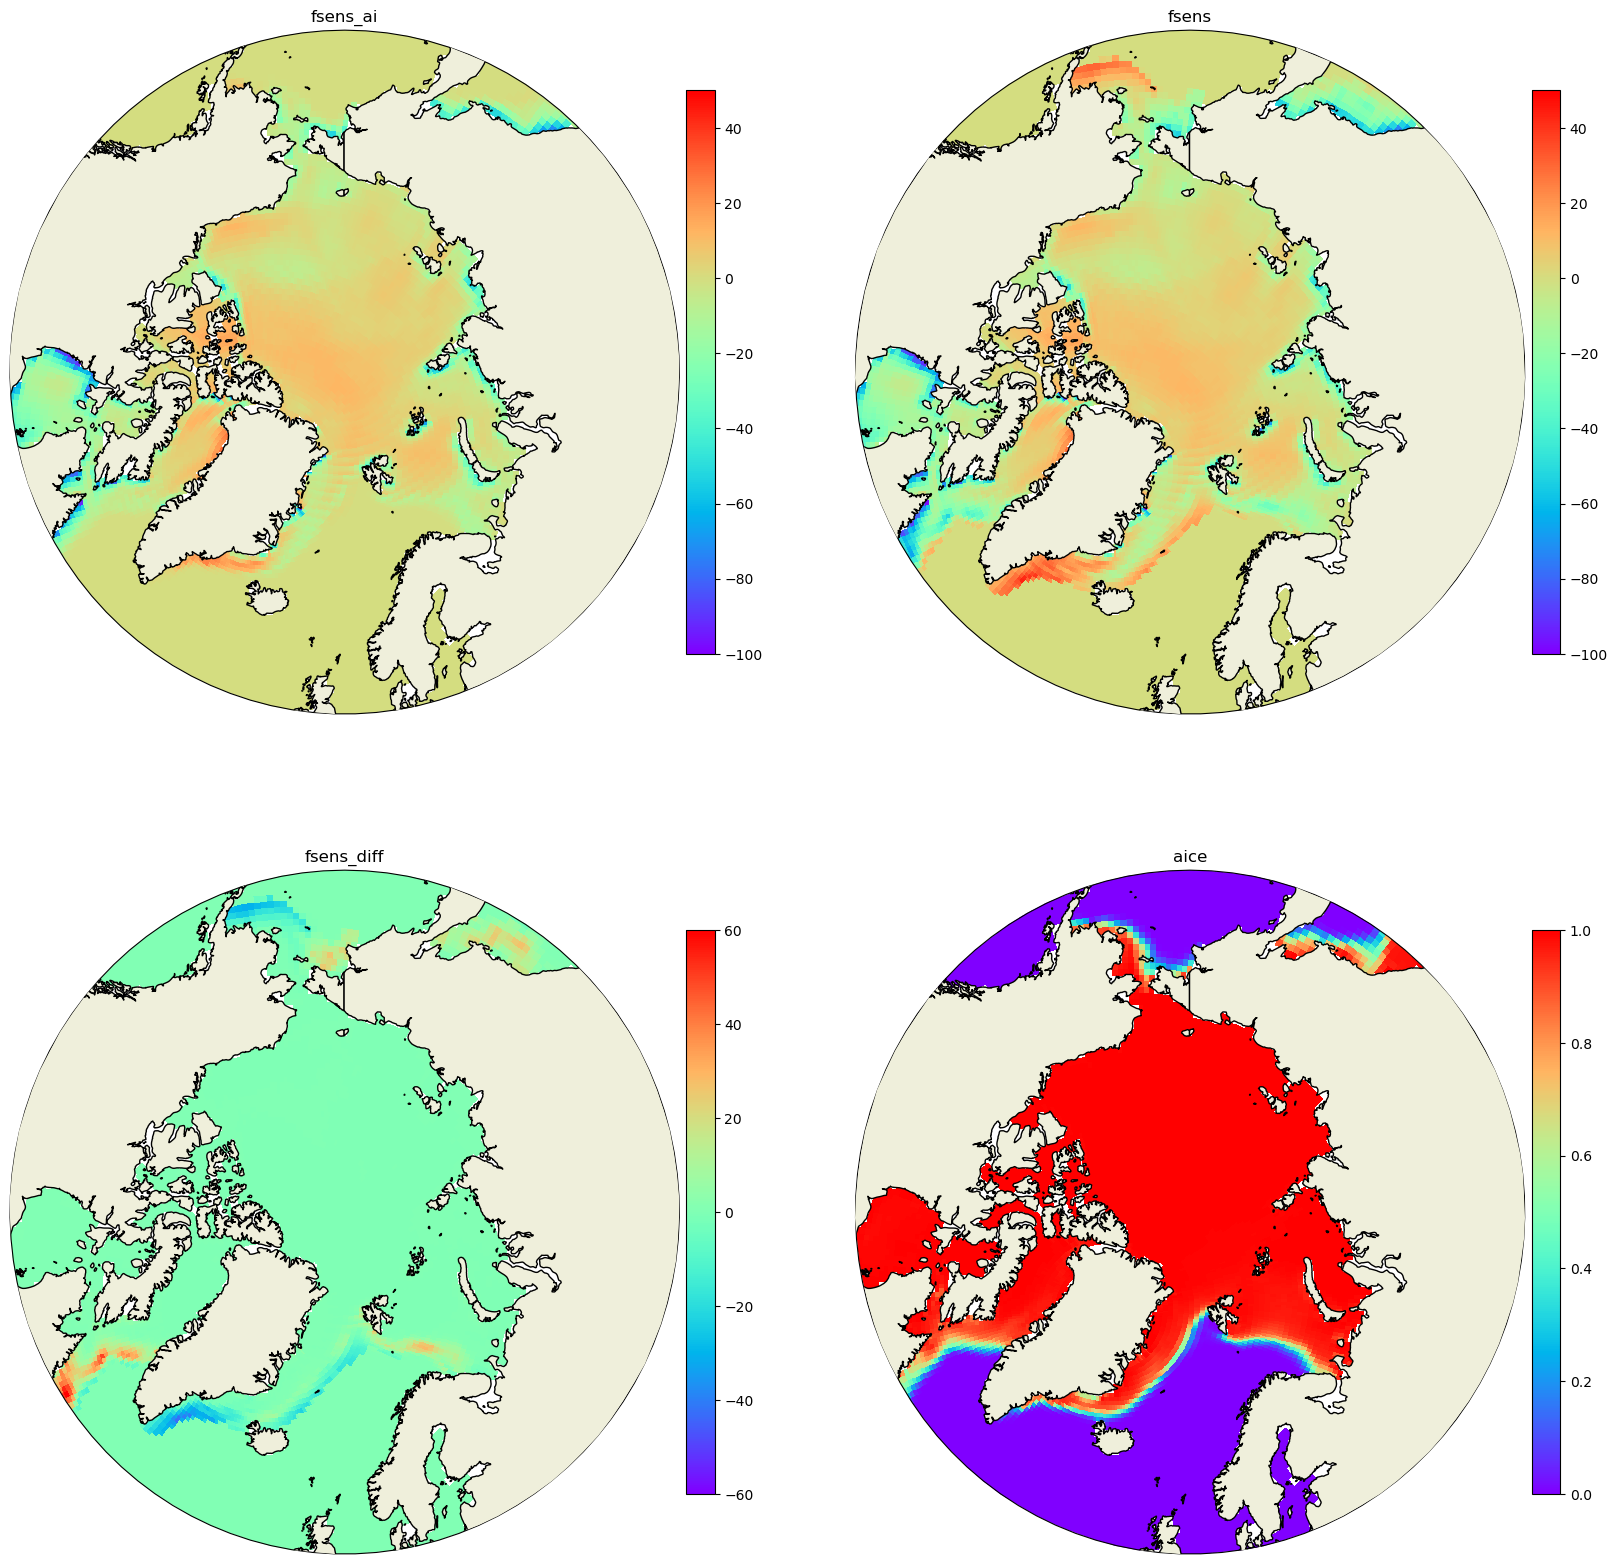

In [43]:
# Min and max
mins = [-100, -100, -60, 0]
maxs = [50, 50, 60, 1]

# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

cmap = plt.cm.get_cmap('rainbow')  

vars_to_plt = ['fsens_ai', 'fsens', 'fsens_diff', 'aice']

fig, axs = plt.subplots(2, 2, figsize=(20,20),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
axs = np.ravel(axs)

for i in np.arange(4):
    ax = axs[i]
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, 90, 55], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(ds['TLONG'],
                       ds['TLAT'],
                       ds[vars_to_plt[i]].sel({'time':'1850-02-01 00:00:00'}
                                             ).squeeze(),
                       cmap=cmap,vmax=maxs[i],vmin=mins[i],
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='vertical',fraction=0.04,pad=0.01)
    ax.set_title(vars_to_plt[i])



Where are the differences most pronounced and why?